# Assignment 2 - Deep Learning, CNN over Fasion MNIST
Maya Kerem 204818181 | Adi Gotliber 205486491

In this assignment you are requested to build a convolutional network and train it over the Fasion MNIST data, which is a collection of 28X28 back and white images, classified into 10 different classes of clothing items. For more information about Fashion MNIST you may refer to:
https://github.com/zalandoresearch/fashion-mnist

In [ ]:
# Loading Fashion MNIST

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np


trainset_minst = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset_minst = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100%|██████████| 26421880/26421880 [00:01<00:00, 15878988.36it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271135.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5035448.12it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6493917.89it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Use dataloaders for train and test (batch size is 4)
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset_minst, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset_minst, batch_size=batch_size,
                                         shuffle=False)

In [ ]:
# The images are of 1, 28, 28 size (only one black-white channel)
print(f'Image size {trainset_minst[0][0].shape}')

Image size torch.Size([1, 28, 28])


# **Part 1**: Implementing a CNN network for Fashion MNIST
Here is what you need to do; you are encoureged to look at notebook "DL Notebook 9 - CIFAR CNN" when trying to complete the next steps.


Write a network CNNFMnist, that has the following architecture:

* Convolution with 10 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 5 3X3 filters
* Relu
* Convolution with 16 3X3 filters
* Relu
* Max pool with 2X2
* Liner, output size 128
* Relu
* Liner, output size 64
* Relu
* Liner, output size 10

In [ ]:
# Hyper-parameters
input_size = 1*28*28 # Image volumn 1*28x28
num_classes = 10 # we have fashion classes

class CNNFMnist(nn.Module):

    def __init__(self):
        super(CNNFMnist, self).__init__()
        self.input_size = input_size
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        # Convolution with 10 3X3 filters
        self.conv1 = nn.Conv2d(1,10,3)
        # Max pool with 2X2
        self.maxpool = nn.MaxPool2d(2,2)
        # Convolution with 5 3X3 filters
        self.conv2 = nn.Conv2d(10,5,3)
        # Convolution with 16 3X3 filters
        self.conv3 = nn.Conv2d(5,16,3)
        # Linear, output size 128
        self.linear1 = nn.Linear(256, 128)
        # Linear, output size 64
        self.linear2 = nn.Linear(128, 64)
        # Linear, output size 10 because of 10 classes
        self.linear3 = nn.Linear(64, num_classes)


    def forward(self, x):
      out = self.conv1(x)
      # the output will be 10*26*26
      out = self.relu(out)
      out = self.maxpool(out)
      # the output will be 10*13*13
      out = self.conv2(out)
      # the output will be 5*11*11
      out = self.relu(out)
      out = self.conv3(out)
      # the output will be 16*9*9
      out = self.relu(out)
      out = self.maxpool(out)
      # the output will be 16*4*4
      out = self.flat(out)
      # the output will be 256
      out = self.linear1(out)
      # the output will be 128
      out = self.relu(out)
      out = self.linear2(out)
      # the output will be 64
      out = self.relu(out)
      h = out
      out = self.linear3(out)
      # the output will be 10(num of classes)
      return h, out

Write a code that trains the network with FashionMNIST train dataset, for classification (use cross entropy, and SGD).
Run the network for at least 10 epochs, over the entire dataset. Make sure to print the loss over the train set as well as the **test set** over time (say, every 1000 batches, but it's up to you), so you will know where you are during training.

Note, measuring loss of test is similar to measuring loss over the train test. However, make sure not to run the test images in back propagation. Use them only in forward and calulate the average loss over the entire test set. Since it will make the training process run slower, you should measure loss for the test set only at the end of an epoch (so overall you get 10 loss values for the test set). You are encoureged to write a different function for claculating the loss of the test set, and then call it from the training procedure.


You should collect the loss values in an array, so you can plot then into two curves, one for train and one for test.

In addition, you should measure the time it takes you to train the network completely.



In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def eval(net, testloader, hardware, trans = False):
  running_loss_test = 0
  with torch.no_grad():
    for j, data in enumerate(testloader, 0):
      inputs, labels = data
      if hardware == 'GPU':
        inputs = inputs.cuda() # -- For GPU
        labels = labels.cuda() # -- For GPU
      if trans == True:
        # For part 3, when considering without the last layer, denoted as h
        outputs, _ = net(inputs) # forward pass
      else:
        _ , outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # loss
      running_loss_test += loss.item()
    print(f'Test loss: {running_loss_test / j+1}')
    return running_loss_test / j+1


def run_model(net, epoch_num, trainloader, testloader, print_batch, hardware = 'CPU', trans = False):
  history_train = []
  history_test = []
  for epoch in range(epoch_num):
    print(f'Epoch {epoch + 1}/{epoch_num}')
    running_loss_train = 0.0
    running_loss_test = 0.0
    # train epoch
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data
      if hardware == 'GPU':
        inputs = inputs.cuda() # -- For GPU
        labels = labels.cuda() # -- For GPU
      optimizer.zero_grad()      # zero the parameter gradients
      if trans == True:
        # For part 3, when considering without the last layer, denoted as h
        outputs, _ = net(inputs) # forward pass
      else:
        _ , outputs = net(inputs) # forward pass

      loss = criterion(outputs, labels) # loss
      loss.backward()   # calc gradients - forward pass
      optimizer.step()  # update weights
      # print statistics
      running_loss_train += loss.item()
      if (i+1) % print_batch == 0:
        print('batches [%d, %5d] train loss: %.3f' % (epoch + 1, i + 1, running_loss_train / print_batch))
    # test epoch
    running_loss_test = (eval(net, testloader, hardware, trans))
    history_train.append(running_loss_train / i+1)
    history_test.append(running_loss_test)

  return history_train, history_test

Write a function that evaluates the resulted model over the entire test data of FashionMNIST. Provide a single accuracy number.

In [ ]:
def get_accuracy(net, testloader, hardware = 'CPU', trans = False):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      if hardware == 'GPU':
        if type(inputs) != torch.Tensor:
            inputs = torch.tensor(inputs)
        if type(labels) != torch.Tensor:
            labels = torch.tensor(labels)
        inputs = inputs.cuda()  # -- for GPU
        labels = labels.cuda()  # -- for GPU
      if trans == True:
        # For part 3, when considering without the last layer, denoted as h
        outputs, _ = net(inputs) # forward pass
      else:
        _ , outputs = net(inputs) # forward pass
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f'Accuracy of the network using {hardware}: %{(100 * correct / total):.2f}')
  return correct / total * 100

# **Part 1**: Model training

In [ ]:
net1 = CNNFMnist().cuda()     # -- For GPU
optimizer = torch.optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
print(net1)

CNNFMnist(
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
%%time
hist_train, hist_test = run_model(net1, 10, trainloader, testloader, 2000, 'GPU', False)

Epoch 1/10
batches [1,  2000] train loss: 2.302
batches [1,  4000] train loss: 4.239
batches [1,  6000] train loss: 5.025
batches [1,  8000] train loss: 5.728
batches [1, 10000] train loss: 6.353
batches [1, 12000] train loss: 6.947
batches [1, 14000] train loss: 7.511
Test loss: 1.5430154899126753
Epoch 2/10
batches [2,  2000] train loss: 0.493
batches [2,  4000] train loss: 1.004
batches [2,  6000] train loss: 1.488
batches [2,  8000] train loss: 1.949
batches [2, 10000] train loss: 2.385
batches [2, 12000] train loss: 2.820
batches [2, 14000] train loss: 3.245
Test loss: 1.4232280356695597
Epoch 3/10
batches [3,  2000] train loss: 0.406
batches [3,  4000] train loss: 0.816
batches [3,  6000] train loss: 1.209
batches [3,  8000] train loss: 1.604
batches [3, 10000] train loss: 1.985
batches [3, 12000] train loss: 2.359
batches [3, 14000] train loss: 2.721
Test loss: 1.3913264548016009
Epoch 4/10
batches [4,  2000] train loss: 0.344
batches [4,  4000] train loss: 0.690
batches [4,  60

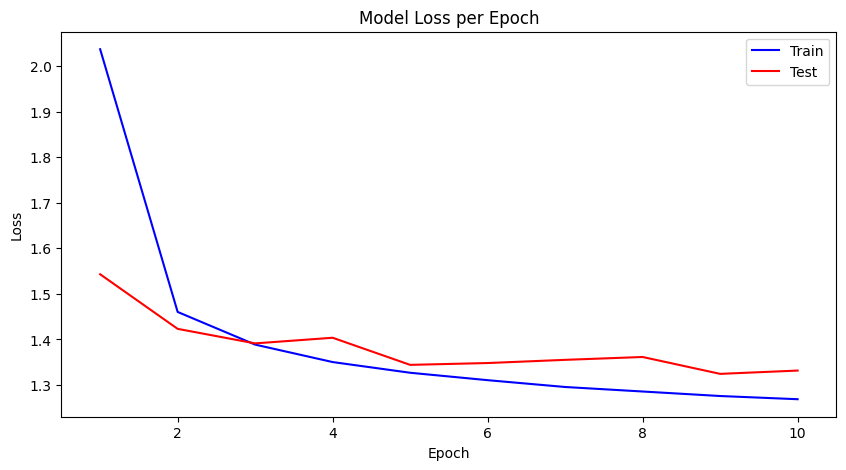

In [ ]:
# Plotting the model history
plt.figure(figsize=(10,5))
epochs = np.arange(1,11)
plt.xlim((0.5,10.5))
plt.grid(False)
plt.plot(epochs, hist_train, color='blue')
plt.plot(epochs, hist_test, color='red')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Train", "Test"])
plt.show()

In [ ]:
_ = get_accuracy(net1, testloader, 'GPU', False)

Accuracy of the network using GPU: %88.10


Creating the new network

# Delution test - random 30%

In [ ]:

def get_accuracy_with_delution_test(net, testloader, hardware = 'CPU', trans = False, delution_precentage = 0.3, seed = 1):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      # Assuming inputs is a tensor of shape (batch_size, channels, height, width)
      batch_size, channels, height, width = inputs.shape
      # Randomly generate a binary mask for each image in the batch
      np.random.seed(seed)
      mask = np.random.choice([0, 1], size=(batch_size, channels, height, width), p=[delution_precentage, 1-delution_precentage])
      mask_tensor = torch.tensor(mask, dtype=float)      # Apply the mask to inputs to delete 30% of the pixels (set them to 0)
      inputs = inputs * mask
      inputs = inputs.type(torch.float32)
      if hardware == 'GPU':
        if type(inputs) != torch.Tensor:
            inputs = torch.tensor(inputs)
        if type(labels) != torch.Tensor:
            labels = torch.tensor(labels)
        inputs = inputs.cuda()  # -- for GPU
        labels = labels.cuda()  # -- for GPU
      if trans == True:
        # For part 3, when considering without the last layer, denoted as h
        outputs, _ = net(inputs) # forward pass
      else:
        _ , outputs = net(inputs) # forward pass
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f'Delution portion: {delution_precentage}| Accuracy of the network: %{(100 * correct / total):.2f}')
  return correct / total * 100


In [ ]:
_ = get_accuracy(net1, testloader, 'GPU', False)

Accuracy of the network using GPU: %88.10


# **Part 2**: Model testin

In [ ]:
_ = get_accuracy(net1, testloader, 'GPU', False)

Accuracy of the network using GPU: %88.10


Testing the model in multiple retuntion levels

In [ ]:
dilution_sizes = np.arange(0, 1, 0.1)
results = {round(key,1): {'accuracy': []} for key in dilution_sizes}
for p in results.keys():
  for iter in range (10):
    acc = get_accuracy_with_delution_test(net1, testloader, 'GPU', False, delution_precentage = p, seed=iter)
    results[p]['accuracy'].append(acc)


Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.0| Accuracy of the network: %88.10
Delution portion: 0.1| Accuracy of the network: %79.51
Delution portion: 0.1| Accuracy of the network: %79.50
Delution portion: 0.1| Accuracy of the network: %81.03
Delution portion: 0.1| Accuracy of the network: %80.58
Delution portion: 0.1| Accuracy of the network: %80.13
Delution portion: 0.1| Accuracy of the network: %79.68
Delution portion: 0.1| Accuracy of the network: %80.91
Delution portion: 0.1| Accuracy of the network: %81.70
Delution p

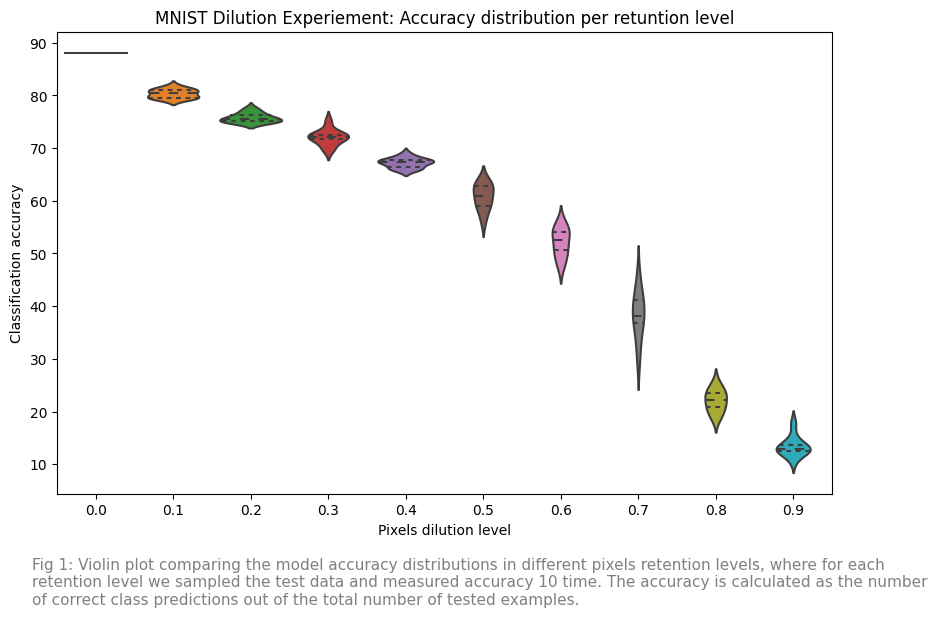

In [ ]:
# Violin Plots
def plot_violin_metrics(results):
    acc_data = [result['accuracy'] for result in results.values()]
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=acc_data, inner='quartile')
    plt.xticks(np.arange(len(results)), list(results.keys()))
    plt.xlabel('Pixels dilution level')
    plt.ylabel('Classification accuracy')
    plt.title('MNIST Dilution Experiement: Accuracy distribution per retuntion level')
    caption = "Fig 1: Violin plot comparing the model accuracy distributions in different pixels retention levels, where for each retention level we sampled the test data and measured accuracy 10 time. The accuracy is calculated as the number of correct class predictions out of the total number of tested examples."
    plt.figtext(0.1, -0.07, caption,  ha='left', fontsize=11, color='gray', wrap=True)
    plt.show()

plot_violin_metrics(results)

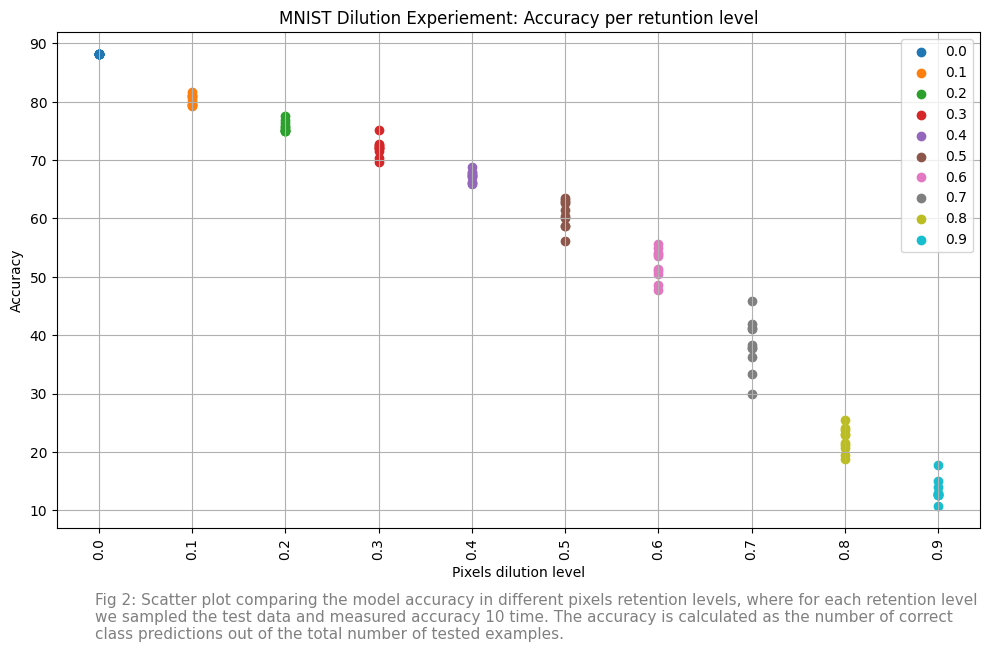

In [ ]:
def plot_scatter(results):
  keys = list(results.keys())
  accuracy_values = [accuracy['accuracy'] for accuracy in results.values()]
  # Create a scatter plot
  plt.figure(figsize=(10, 6))
  for i, accuracies in enumerate(accuracy_values):
      x_values = [i] * len(accuracies)
      plt.scatter(x_values, accuracies, label=keys[i])

  plt.xlabel('Pixels dilution level')
  plt.ylabel('Accuracy')
  plt.title('MNIST Dilution Experiement: Accuracy per retuntion level')
  plt.xticks(range(len(keys)), keys, rotation='vertical')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  caption = "Fig 2: Scatter plot comparing the model accuracy in different pixels retention levels, where for each retention level we sampled the test data and measured accuracy 10 time. The accuracy is calculated as the number of correct class predictions out of the total number of tested examples."
  plt.figtext(0.1, -0.07, caption,  ha='left', fontsize=11, color='gray', wrap=True)

  plt.show()

plot_scatter(results)

 Retention level 1.0


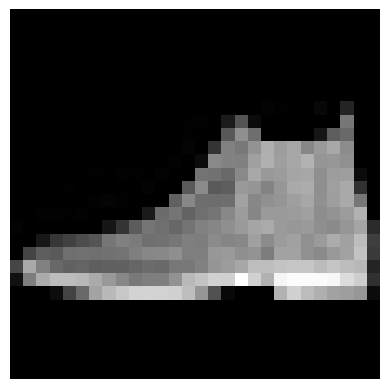

 Retention level 0.9


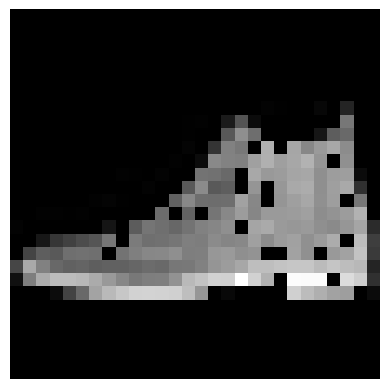

 Retention level 0.8


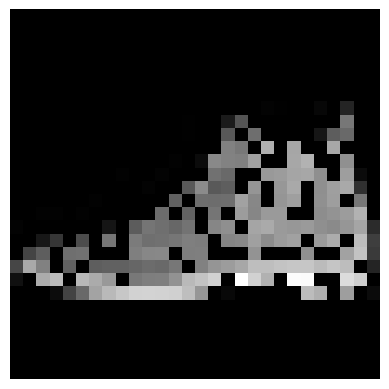

 Retention level 0.7


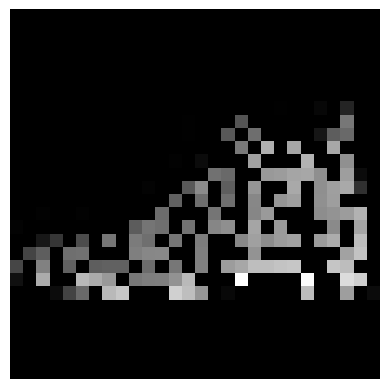

 Retention level 0.6


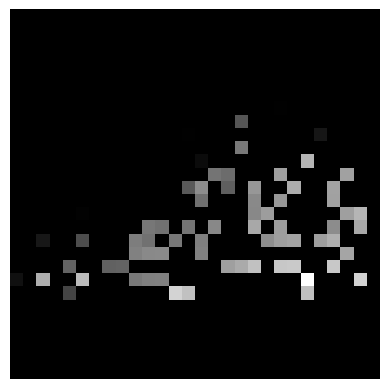

 Retention level 0.5


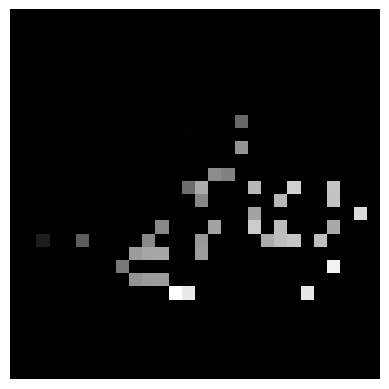

 Retention level 0.4


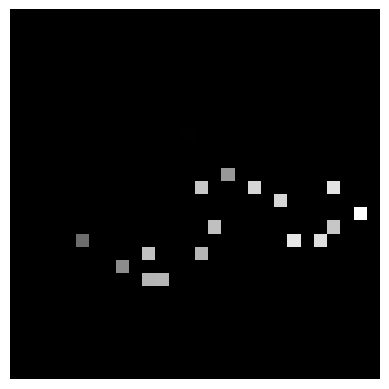

 Retention level 0.3


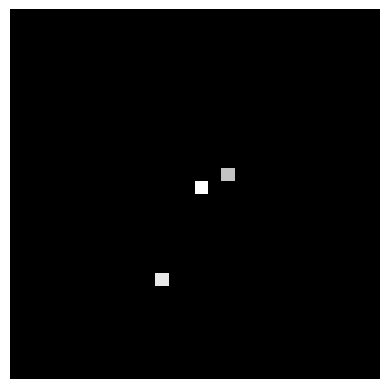

 Retention level 0.2


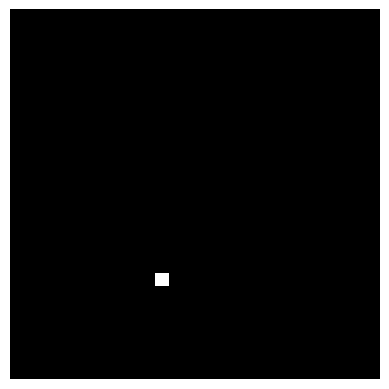

 Retention level 0.1


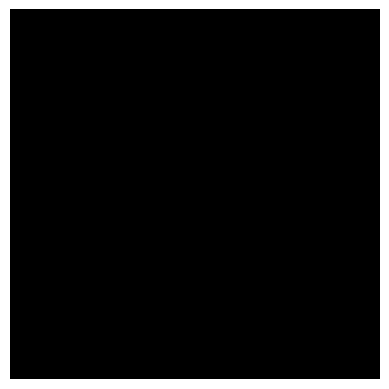

In [ ]:

# visualisation example of the delotion test
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
output_image = Image.new('RGB', (30, 300), (255, 255, 255))

i = 0
for data in testloader:
    i += 1
    inputs, labels = data

    # Assuming inputs is a tensor of shape (batch_size, channels, height, width)
    batch_size, channels, height, width = inputs.shape
    for p in np.arange(0, 1, 0.1):
      print(f" Retention level {round(1-p,1)}")
      # for i in range(batch_size):
      mask = np.random.choice([0, 1], size=(channels, height, width), p=[round(p,1), round(1-p, 1)])
      mask_tensor = torch.tensor(mask, dtype=inputs.dtype)      # Apply the mask to inputs to delete 30% of the pixels (set them to 0)
      # Apply the mask to inputs to delete 30% of the pixels (set them to 0)
      # inputs = inputs * mask
      inputs = inputs * mask
      inputs = inputs.type(torch.float32)
      image_array = inputs[0][0]  # Assuming grayscale
      # Display the modified image
      plt.imshow(image_array, cmap='gray')
      plt.axis('off')
      plt.show()
      # break
    break





In [ ]:
net = net1
trans = True
hardware = 'GPU'
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
          inputs, labels = data
          # Assuming inputs is a tensor of shape (batch_size, channels, height, width)
          batch_size, channels, height, width = inputs.shape
          # Randomly generate a binary mask for each image in the batch

          for delution_precentage in np.arange(0, 1, 0.1):
                  print(delution_precentage)
                  np.random.seed(1)
                  mask = np.random.choice([0, 1], size=(batch_size, channels, height, width), p=[delution_precentage, 1-delution_precentage])
                  mask_tensor = torch.tensor(mask, dtype=float)      # Apply the mask to inputs to delete 30% of the pixels (set them to 0)
                  inputs = inputs * mask
                  inputs = inputs.type(torch.float32)
                  if hardware == 'GPU':
                    if type(inputs) != torch.Tensor:
                        inputs = torch.tensor(inputs)
                    if type(labels) != torch.Tensor:
                        labels = torch.tensor(labels)
                    inputs = inputs.cuda()  # -- for GPU
                    labels = labels.cuda()  # -- for GPU
                  if trans == True:
                    # For part 3, when considering without the last layer, denoted as h
                    outputs, _ = net(inputs) # forward pass
                  else:
                    _ , outputs = net(inputs) # forward pass
                  _, predicted = torch.max(outputs.data, 1)

                  print(predicted)
                  print(labels)

                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
          break
  print(f'Delution portion: {delution_precentage}| Accuracy of the network: %{(100 * correct / total):.2f}')


In [ ]:
np.arange(0, 1, 0.1)